<a href="https://colab.research.google.com/github/useruser1234name/diabetes-analysis/blob/main/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 당뇨병 위험 예측 및 고위험군 분석 프로젝트

본 분석은 당화혈색소 수치(`glyhb`)를 기준으로 당뇨병 위험을 분류하고, 머신러닝 모델과 클러스터링을 통해 고위험군을 식별합니다.


In [20]:
# !pip install streamlit
# !pip install plotly

In [131]:
#필수 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

#머신러닝 관련 라이브러리
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


## 데이터 준비 및 전처리

- **데이터셋**: 당뇨병 관련 임상 데이터(`diabetes.csv`)
- **불필요한 컬럼 제거**: `bp.2s`, `bp.2d`, `id`
- **BMI 계산**: 키와 몸무게로부터 새롭게 생성
- **결측치 제거**: 완전한 데이터만 사용
- **범주형 변수 인코딩**: `location`, `gender`, `frame` 등


In [132]:
data = pd.read_csv("/content/diabetes.csv")

In [133]:
print(data.shape, '\n')
print(data.describe(), '\n')
print(data.info(), '\n')
print(data.isnull().sum(), '\n')
data.head(10)

(403, 19) 

                 id        chol    stab.glu         hdl       ratio  \
count    403.000000  402.000000  403.000000  402.000000  402.000000   
mean   15978.310174  207.845771  106.672457   50.445274    4.521642   
std    11881.122124   44.445557   53.076655   17.262626    1.727886   
min     1000.000000   78.000000   48.000000   12.000000    1.500000   
25%     4792.500000  179.000000   81.000000   38.000000    3.200000   
50%    15766.000000  204.000000   89.000000   46.000000    4.200000   
75%    20336.000000  230.000000  106.000000   59.000000    5.400000   
max    41756.000000  443.000000  385.000000  120.000000   19.299999   

            glyhb         age      height      weight       bp.1s       bp.1d  \
count  390.000000  403.000000  398.000000  402.000000  398.000000  398.000000   
mean     5.589769   46.851117   66.020101  177.592040  136.904523   83.321608   
std      2.242595   16.312333    3.918515   40.340666   22.741033   13.589227   
min      2.680000   19.0

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0
5,1008,248.0,94,69.0,3.6,4.81,Buckingham,34,male,71.0,190.0,large,132.0,86.0,NaN,NaN,36.0,42.0,195.0
6,1011,195.0,92,41.0,4.8,4.84,Buckingham,30,male,69.0,191.0,medium,161.0,112.0,161.0,112.0,46.0,49.0,720.0
7,1015,227.0,75,44.0,5.2,3.94,Buckingham,37,male,59.0,170.0,medium,NaN,NaN,NaN,NaN,34.0,39.0,1020.0
8,1016,177.0,87,49.0,3.6,4.84,Buckingham,45,male,69.0,166.0,large,160.0,80.0,128.0,86.0,34.0,40.0,300.0
9,1022,263.0,89,40.0,6.6,5.78,Buckingham,55,female,63.0,202.0,small,108.0,72.0,NaN,NaN,45.0,50.0,240.0


In [134]:
data_copy = data

In [135]:
# BMI 계산 (height in inches, weight in pounds)
# 1 inch = 0.0254 m, 1 lb = 0.453592 kg
height_m = data_copy["height"] * 0.0254 #inches -> meters
weight_kg = data_copy["weight"] * 0.453592 #poundes -> kg
data_copy["bmi"] = weight_kg / (height_m ** 2)

In [136]:
# 불필요한 결측치가 많은 컬럼 제거 (bp.2s, bp.2d)
data_copy.drop(['bp.2s', 'bp.2d'], axis=1, inplace=True)

In [137]:
# 결측치가 있는 행 제거
data_cleaned = data_copy.dropna().reset_index(drop=True)

In [138]:
# id 컬럼 제거 (고유 식별자이므로 분석에 필요 없음)
data_cleaned.drop("id", axis=1, inplace=True)

In [139]:
# 범주형 변수 인코딩
cat_cols = ["location", "gender", "frame"]
for col in cat_cols:
    data_cleaned[col] = data_cleaned[col].astype("category").cat.codes

# 처리 후 shape 확인
print("전처리 후 데이터 shape:", data_cleaned.shape, '\n')
data_cleaned.head(10)

전처리 후 데이터 shape: (366, 17) 



,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn,bmi
0,203.0,82,56.0,3.6,4.31,0,46,0,62.0,121.0,1,118.0,59.0,29.0,38.0,720.0,22.130944
1,165.0,97,24.0,6.9,4.44,0,29,0,64.0,218.0,0,112.0,68.0,46.0,48.0,360.0,37.419200
2,228.0,92,37.0,6.2,4.64,0,58,0,61.0,256.0,0,190.0,92.0,49.0,57.0,180.0,48.370241
3,78.0,93,12.0,6.5,4.63,0,67,1,67.0,119.0,0,110.0,50.0,33.0,38.0,480.0,18.637828
4,249.0,90,28.0,8.9,7.72,0,64,1,68.0,183.0,1,138.0,80.0,44.0,41.0,300.0,27.824747
5,248.0,94,69.0,3.6,4.81,0,34,1,71.0,190.0,0,132.0,86.0,36.0,42.0,195.0,26.499328
6,195.0,92,41.0,4.8,4.84,0,30,1,69.0,191.0,1,161.0,112.0,46.0,49.0,720.0,28.205457
7,177.0,87,49.0,3.6,4.84,0,45,1,69.0,166.0,0,160.0,80.0,34.0,40.0,300.0,24.513643
8,263.0,89,40.0,6.6,5.78,0,55,0,63.0,202.0,2,108.0,72.0,45.0,50.0,240.0,35.782298
9,242.0,82,54.0,4.5,4.77,1,60,0,65.0,156.0,1,130.0,90.0,39.0,45.0,300.0,25.959471


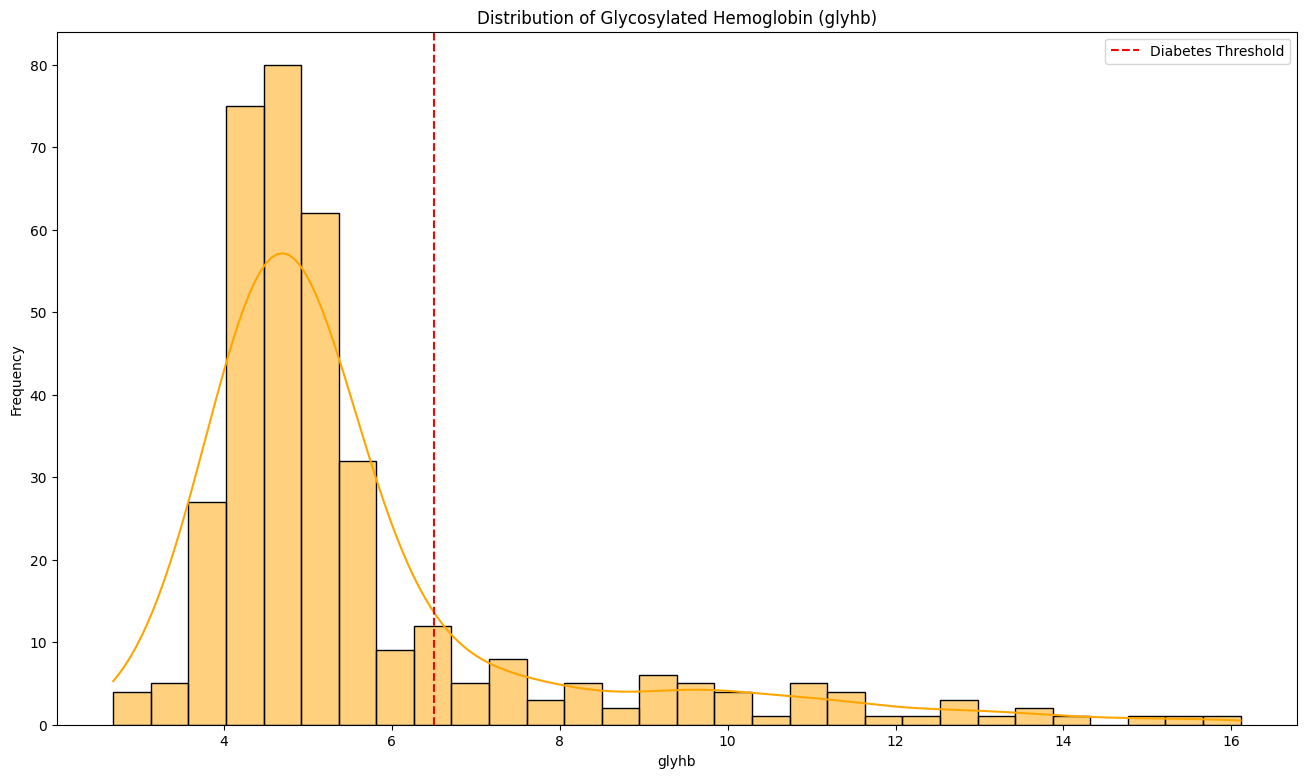

In [140]:
# glyhb(당화혈색소) 분포 시각화
plt.figure(figsize=(16, 9))
sns.histplot(data_cleaned['glyhb'], bins=30, kde=True, color='orange')
plt.axvline(x=6.5, color='red', linestyle='--', label='Diabetes Threshold')
plt.title("Distribution of Glycosylated Hemoglobin (glyhb)")
plt.xlabel("glyhb")
plt.ylabel("Frequency")
plt.legend()
plt.show()

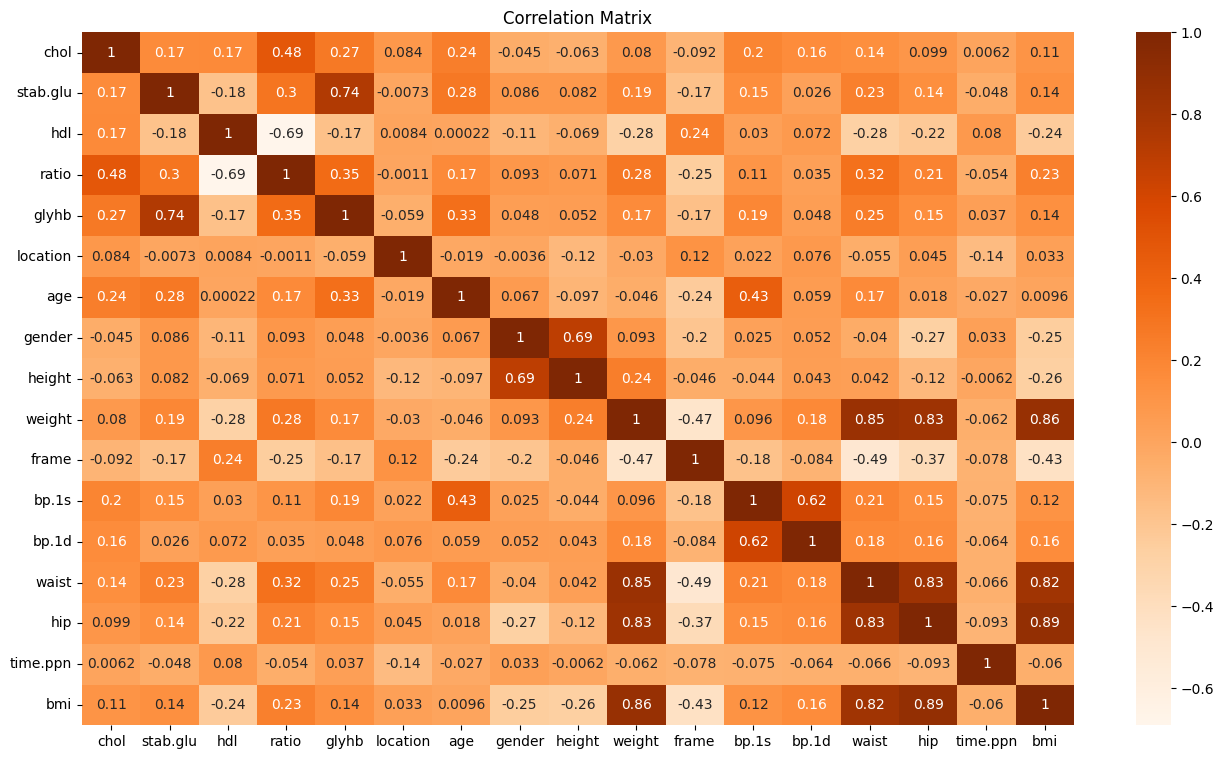

In [141]:
# 히트맵으로 상관관계 시각화
plt.figure(figsize=(16,9))
sns.heatmap(data_cleaned.corr(), annot=True, cmap="Oranges")
plt.title("Correlation Matrix")
plt.show()

In [142]:
# 주요 Feature vs glyhb 시각화 함수 정의
def plot_feature_vs_target(df, feature):
    fig = px.scatter(df, x=feature, y="glyhb", size="age", color_discrete_sequence=['orange'])
    fig.add_hline(y=6.5, line_dash="dash", line_color="black")
    fig.update_layout(title=f"{feature} vs Glycosylated Hemoglobin (glyhb)",
                      xaxis_title=feature, yaxis_title="glyhb",
                      plot_bgcolor='white')
    fig.show()

# 주요 변수 시각화
important_features = ['chol', 'stab.glu', 'hdl', 'ratio', 'age', 'bmi', 'bp.1s', 'bp.1d', 'waist', 'hip']
for feature in important_features:
    plot_feature_vs_target(data_cleaned, feature)

In [143]:
# 타겟 변수 이진화 (6.5 기준으로 당뇨 여부 판단)
data_cleaned["diabetes"] = (data_cleaned["glyhb"] > 6.5).astype(int)

## 타겟 변수 생성

- `glyhb > 6.5`를 기준으로 당뇨 여부를 이진화 → `diabetes` 컬럼 생성

In [144]:
# 타겟 및 특성 분리
X = data_cleaned.drop(["glyhb", "diabetes"], axis=1)
y = data_cleaned["diabetes"]


## 특성 스케일링

- `StandardScaler`로 모든 변수 정규화 → 모델 간 성능 일관성 유지

In [145]:
# 데이터 정규화 (랜덤포레스트에는 꼭 필요하진 않지만 다른 모델 대비 호환성 위해 적용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 분류모델 학습
### 모델
  - **Random Forest**
  - **Logistic Regression**

In [147]:
# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [148]:
# 모델 학습 - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

In [149]:
# 모델 학습 - Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]

### 평가
  - `classification_report`, `ROC Curve`, `AUC Score`로 모델 성능 비교
  - **Random Forest가 높은 AUC**로 더 나은 성능 보임

In [150]:
print("Random Forest:\n", classification_report(y_test, rf_pred))
print("Logistic Regression:\n", classification_report(y_test, lr_pred))

Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        63
           1       1.00      0.73      0.84        11

    accuracy                           0.96        74
   macro avg       0.98      0.86      0.91        74
weighted avg       0.96      0.96      0.96        74

Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        63
           1       0.88      0.64      0.74        11

    accuracy                           0.93        74
   macro avg       0.91      0.81      0.85        74
weighted avg       0.93      0.93      0.93        74



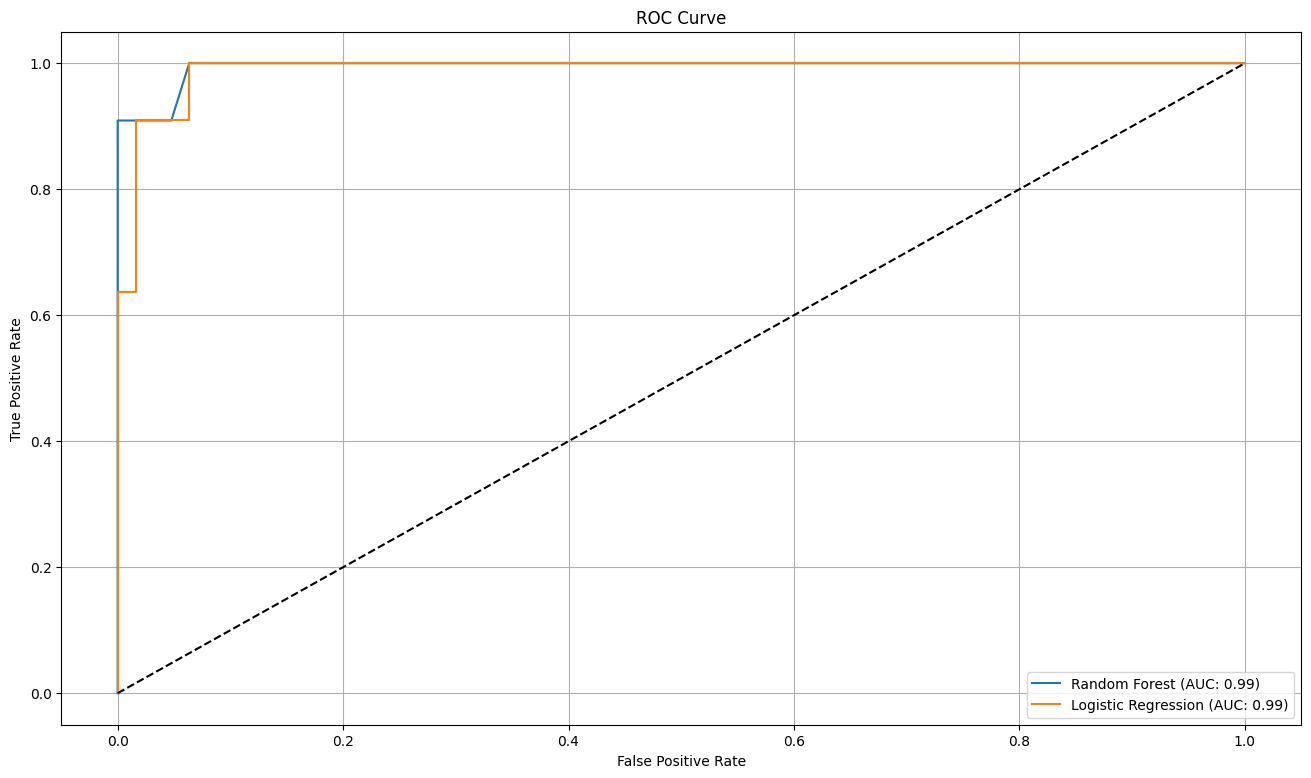

In [152]:
# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)

plt.figure(figsize=(16,9))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC: {roc_auc_score(y_test, rf_proba):.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC: {roc_auc_score(y_test, lr_proba):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

## 피처 중요도 분석

- **가장 중요한 변수**: `stab.glu` (공복혈당), `age`, `bmi` 등
- 시각화를 통해 해석 가능


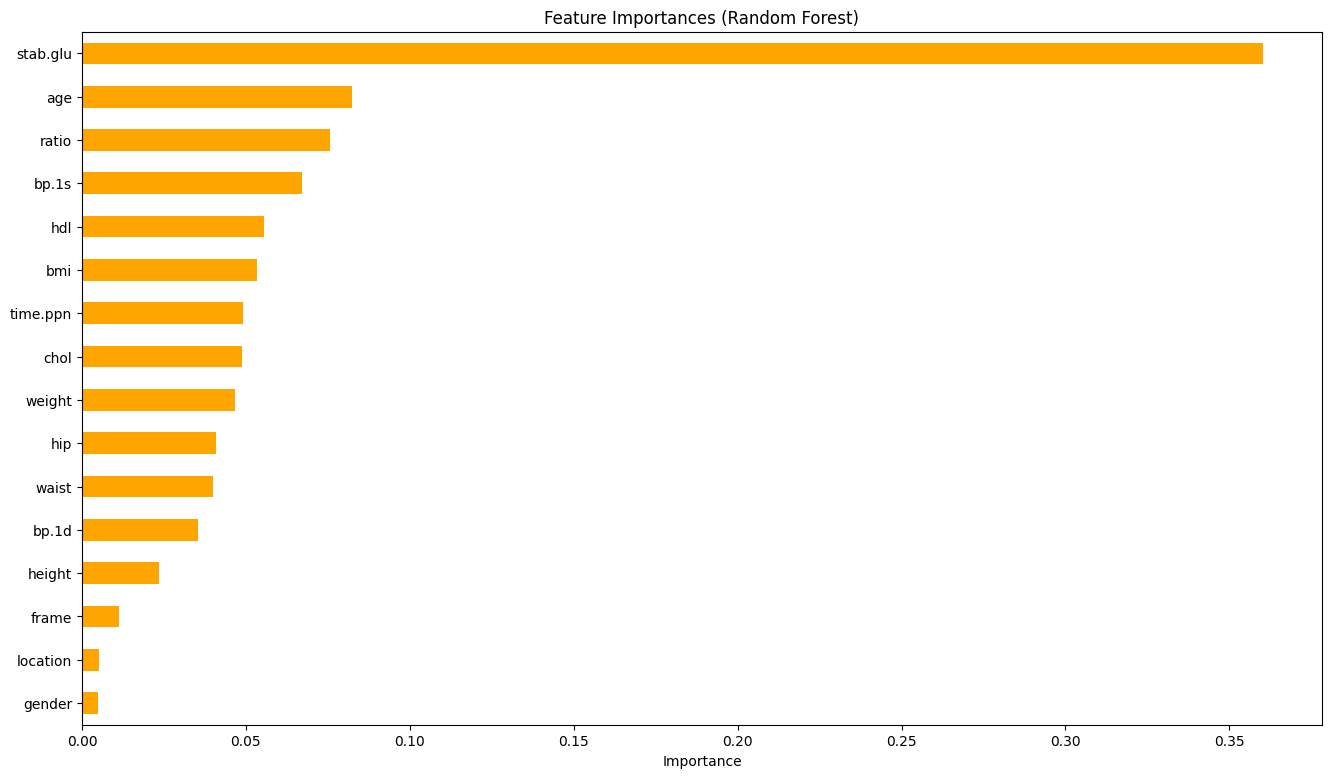

In [153]:
# Feature Importance (Random Forest 기준)
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(16,9))
feat_importances.sort_values().plot(kind='barh', color='orange')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

## 클러스터링 분석 (KMeans)

- 3개 군집으로 환자 분류
- 주요 변수: `age`, `glyhb`, `bmi`
- **군집별 특성 요약**:
  - 평균 혈당, 평균 나이, 평균 BMI, 당뇨율 등

In [121]:
# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
data_cleaned["RiskCluster"] = cluster_labels.astype(str) #문자열로 변환하여 색 지정

color_sequence = ["#636EFA", "#EF553B", "#00CC96"]

# 클러스터 시각화
fig = px.scatter(
    data_cleaned,
    x="age",
    y="glyhb",
    color="RiskCluster", #범주형으로 인식
    title="Risk Group Clustering: Age vs GlyHb",
    labels={"glyhb": "Glycohemoglobin", "age": "Age"},
    hover_data=["diabetes"],
    color_discrete_sequence=color_sequence
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.show()

# 클러스터 평균 요약
cluster_summary = data_cleaned.groupby("RiskCluster").agg({
    "glyhb": "mean",
    "age": "mean",
    "bmi": "mean",
    "diabetes": "mean"
}).rename(columns={"diabetes": "diabetes_rate"})

print("\n클러스터별 평균 특성:")
print(cluster_summary)


클러스터별 평균 특성:
                glyhb        age        bmi  diabetes_rate
RiskCluster                                               
0            6.490763  50.940678  35.507445       0.322034
1            5.092464  43.384058  26.742579       0.094203
2            5.305455  46.281818  24.216963       0.090909


In [155]:
#위험군 분류 리포트
print("\n위험군 분류 리포트")
cluster_sorted = cluster_summary.sort_values(by="glyhb", ascending=False)
for i, (cluster_id, row) in enumerate(cluster_sorted.iterrows(), 1):
    print(f"{i}순위 위험군 (Cluster {cluster_id}):")
    print(f"- 평균 혈당(GlyHb): {row['glyhb']:.1f}")
    print(f"- 평균 나이: {row['age']:.1f}")
    print(f"- 평균 BMI: {row['bmi']:.1f}")
    print(f"- 당뇨병 비율: {row['diabetes_rate']*100:.1f}%\n")


위험군 분류 리포트
1순위 위험군 (Cluster 0):
- 평균 혈당(GlyHb): 6.5
- 평균 나이: 50.9
- 평균 BMI: 35.5
- 당뇨병 비율: 32.2%

2순위 위험군 (Cluster 2):
- 평균 혈당(GlyHb): 5.3
- 평균 나이: 46.3
- 평균 BMI: 24.2
- 당뇨병 비율: 9.1%

3순위 위험군 (Cluster 1):
- 평균 혈당(GlyHb): 5.1
- 평균 나이: 43.4
- 평균 BMI: 26.7
- 당뇨병 비율: 9.4%



# 당뇨병 고위험군 예측 분석 보고서

## 분석 목적
- 당화혈색소 수치를 기준으로 당뇨병 여부를 예측
- 머신러닝과 클러스터링을 통해 고위험군을 자동 식별
- 쉽게 이해 가능하도록 시각화 자료와 리포트를 제공

---

## 주요 분석 내용

1. **BMI 재산출**: 키/몸무게로 정확한 비만도 반영
2. **랜덤포레스트 및 로지스틱 회귀모델**로 예측 수행
3. **ROC Curve** 비교 결과, 랜덤포레스트가 더 우수한 성능
4. **피처 중요도 분석 결과**: 혈당(glyhb), 공복혈당(stab.glu), 나이, BMI가 주요 변수
5. **KMeans 클러스터링**을 통해 3개 군집으로 자동 분류
6. **자동 해석 리포트**로 고위험군의 특성 제시

---

## 위험군 특징 요약

| 클러스터 | 평균 혈당 | 평균 나이 | 평균 BMI | 당뇨율 | 위험도 |
|----------|-----------|-----------|-----------|--------|--------|
| 0        | 6.5       | 50.9세    | 35.5      | 32.2%  | 고위험 |
| 2        | 5.3       | 46.3세    | 24.2      | 9.1%   | 중간위험 |
| 1        | 5.1       | 43.4세    | 26.7      | 9.4%   | 저위험 |

---

## 결론

- 혈당 수치는 모델과 클러스터링 양쪽에서 **가장 핵심적인 위험 판단 기준**
- BMI는 위험도에 영향을 주지만, **혈당이 분류 기준에 결정적**

---

## 활용 방안

- 건강검진 후 고위험군 자동 식별 시스템
- 의료진 개입이 필요한 타겟 환자 우선순위 결정
- 비전문가용 건강 리포트 자동 생성 가능
